(qml103)=
# QML 103 - Teaching the circle


In the [last tutorial](qml102) we saw how deeper algorithms allow us to model more complex dependencies of single input variables and binary labels. However, it is now time to train the algorithms on problems with more than a single input variable it is common in image recognition etc.

In this tutorial, we will introduce slightly more complex data sets and see how we can handle the classification with data reuploading circuits. We will learn:

- that more input parameters require deeper circuits.
- the required dimension of the circuit is only set by the number of labels in the problem. So in this   most basic ideas of quantum machine learning algorithms. 

We will always focus on simplicity throughout this tutorial and leave the more complex discussions to the extensive literature and later tutorials.

In [ ]:
# only necessary on colab to have all the required packages installed

!pip install qiskit
!pip install pylatexenc

And we also install the other dependencies

In [ ]:
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# for splitting the data set
from sklearn.model_selection import train_test_split

# for the quantum circuits
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

## Learning two-dimensional inputs

We will now work with a problem with data that have two-dimensional input $\mathbf{x}_i = (x_{1,i}, x_{2,i})$ and as previously a binary label $y_i \in \{0, 1\}$. A nice example of such a data-set is a circle in a plane as visualized below.

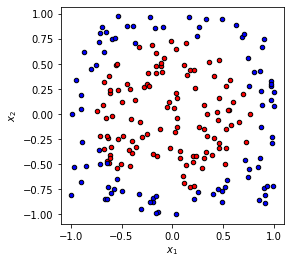

In [ ]:
def circle(samples: int, center: List[float] = [0.0, 0.0], radius:float =np.sqrt(2 / np.pi)) -> Union[np.array, np.array]:
    """
    Produce the data set of a circle in a plane that spans from -1 to +1

    Args:
      sample: The number of samples we would like to generate
      center: where should be the center of the circle
      radius: What should be the radius of the sample
    Returns:
      The array of the xvalues and the array of the labels.
    """
    xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 1
        if np.linalg.norm(x) < radius:
            y = 0
        xvals.append(x)
        yvals.append(y)
    return np.array(xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None, title=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)


xdata, ydata = circle(200)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(xdata, ydata, fig=fig, ax=ax)

Once again we split the data set and get into the training.

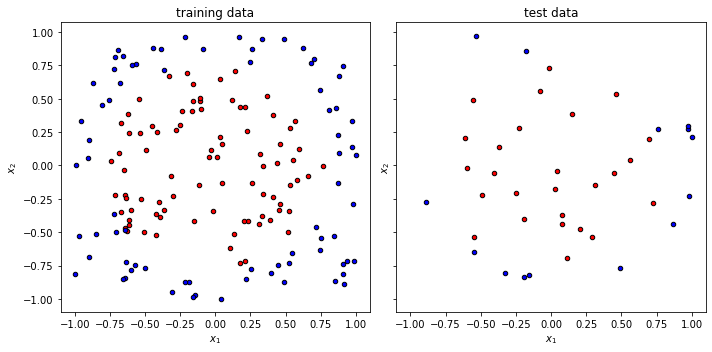

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    xdata, ydata, test_size=0.20, random_state=42
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

plot_data(x_train, y_train, fig=f, ax=ax1, title="training data")
plot_data(x_test, y_test, fig=f, ax=ax2, title="test data")

f.tight_layout()

## Working with multiple inputs

To achieve training now, we have to upload all the input parameters into the circuit. We will once again follow the [data-reuploading approach](https://quantum-journal.org/papers/q-2020-02-06-226/). In summary, we will 

1. Prepare the initial state.
2. Apply a parametrized circuit with parameters $\mathbf{w}$ that depend on the input $U(\mathbf{w}, \mathbf{x}_i)$.
3. Read out the label from the measurement of the qubit.

The main difference is now that the upload $S(\mathbf{x}_i)$ will have multiple rotations. In our fairly simple case of two input parameters, we will then set it as:

$$
\hat{S}(x_{1,i}, x_{2,i}) = \hat{R}_z(w_2 \cdot x_2) \hat{R}_x(w_1 \cdot x_1)
$$

Let us just visualize it once in `qiskit`.

In [ ]:
sim = Aer.get_backend("aer_simulator")

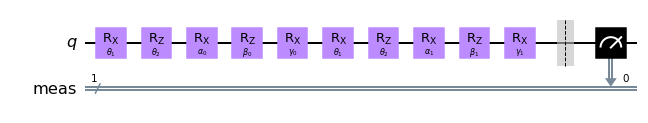

In [ ]:
theta1 = Parameter(r"$\theta_1$")
theta2 = Parameter(r"$\theta_2$")

alpha0 = Parameter(r"$\alpha_0$")
alpha1 = Parameter(r"$\alpha_1$")

beta0 = Parameter(r"$\beta_0$")
beta1 = Parameter(r"$\beta_1$")

gamma0 = Parameter(r"$\gamma_0$")
gamma1 = Parameter(r"$\gamma_1$")


#alpha1 = Parameter(r"$\alpha_1$")
qc = QuantumCircuit(1)

# first upload
qc.rx(theta1, 0)
qc.rz(theta2, 0)

# first processing
qc.rx(alpha0, 0)
qc.rz(beta0, 0)
qc.rx(gamma0, 0)

# second upload
qc.rx(theta1, 0)
qc.rz(theta2, 0)

# second processing
qc.rx(alpha1, 0)
qc.rz(beta1, 0)
qc.rx(gamma1, 0)


qc.measure_all()
qc.draw("mpl")

We can now look at the performance of the code with some randomly initialized weight in predicting the appropiate label.

In [ ]:
def get_accuracy(
    qc: QuantumCircuit, weights: List[float] , alphas: List[float], betas: List[float], gammas: List[float],
    xvals: List[float], yvals: List[int]
) -> Union[float, List[int]]:
    """
    Calculates the accuracy of the circuit for a given set of data.

    Args:
      qc: the quantum circuit
      alphas: the training parameters for the z processing gate
      gammas: the training parameters for the x processing gate
      weights: the weights for the inputs
      xvals: the input values
      yvals: the labels
    Returns:
      The accuracy and the predicted labels.
    """
    pred_labels = np.zeros(len(xvals))
    accurate_prediction = 0
    for ii, xinput, yinput in zip(range(len(xvals)), xvals, yvals.astype(int)):
        # set the circuit parameter
        circuit = qc.assign_parameters(
            {theta1: weights[0]*xinput[0],
             theta2: weights[1]*xinput[1],
             alpha0: alphas[0],
             alpha1: alphas[1],
             beta0: betas[0],
             beta1: betas[1],
             gamma0: gammas[0],
             gamma1: gammas[1],
             },
            inplace=False,
        )
        # run the job and obtain the counts
        Nshots = 4000
        job = sim.run(circuit, shots=Nshots)
        counts1 = job.result().get_counts()

        # obtain the predicted label on average
        if "0" in counts1:
            pred_label = 1 * (counts1["0"] < Nshots/2)
        else:
            pred_label = 1
        pred_labels[ii] = pred_label
        if yinput == pred_label:
            accurate_prediction += 1
    return accurate_prediction / len(yvals), pred_labels

In [ ]:
np.random.seed(123)

weights = np.random.uniform(size=2)
alphas = np.random.uniform(size=2)
betas = np.random.uniform(size=2)
gammas = np.random.uniform(size=2)

accuracy, y_pred = get_accuracy(qc, alphas=alphas, betas = betas, weights=weights, gammas = gammas, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The randomly initialized circuit has an accuracy of {accuracy}")

The randomly initialized circuit has an accuracy of 0.3875


Now it is time to visualize the quality of the prediction with random parameters. We can clearly see that the overlap is ... random.

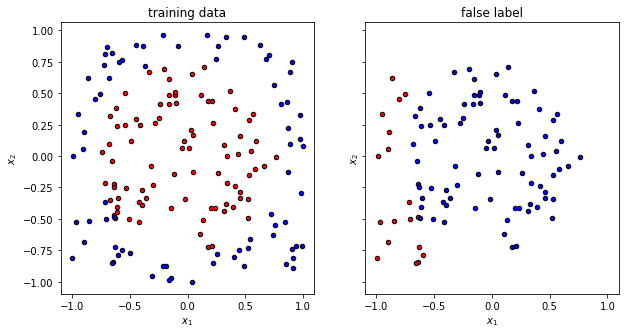

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

plot_data(x_train, y_train, fig=f, ax=ax1, title="training data")
plot_data(x_false, y_false, fig=f, ax=ax2, title="false label")

## Training

We once again have to train the circuit as discussed in the[ previous tutorial](qml102) with [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) package to optimize the target function.

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_cost_for_circ(xvals, yvals, machine=sim):
    """
    Runs parametrized circuit

    Args:
        x: position of the dot
        y: its state label
        params: parameters of the circuit
    """

    def execute_circ(params_flat):
        weights = params_flat[:2]
        alphas = params_flat[2:4]
        betas = params_flat[4:6]
        gammas = params_flat[6:]
        accuracy, y_pred = get_accuracy(qc, alphas=alphas, betas = betas, weights=weights, gammas = gammas, xvals=xvals, yvals=yvals)
        print(f"accuracy = {accuracy}")
        return 1-accuracy

    return execute_circ

In [ ]:
total_cost = get_cost_for_circ(x_train, y_train, sim)

# initial parameters which are randomly initialized
np.random.seed(123)
params = np.random.uniform(size=8)
params_flat = params.flatten()

# initial parameters which are guessed
weights = np.array([1,1])
alphas = [0,0]
betas = [0,0]
gammas = [0,0]
params_flat = np.zeros(8)
#params_flat[:2] = 1

# minimze with COBYLA optimize, which often performs quite well
res = minimize(total_cost, params_flat, method="COBYLA")

accuracy = 0.53125
accuracy = 0.70625
accuracy = 0.6875
accuracy = 0.5875
accuracy = 0.5875
accuracy = 0.5875
accuracy = 0.70625
accuracy = 0.5875
accuracy = 0.5875
accuracy = 0.5
accuracy = 0.6
accuracy = 0.55625
accuracy = 0.70625
accuracy = 0.725
accuracy = 0.71875
accuracy = 0.71875
accuracy = 0.725
accuracy = 0.69375
accuracy = 0.725
accuracy = 0.73125
accuracy = 0.7125
accuracy = 0.73125
accuracy = 0.71875
accuracy = 0.71875
accuracy = 0.74375
accuracy = 0.73125
accuracy = 0.7375
accuracy = 0.71875
accuracy = 0.73125
accuracy = 0.74375
accuracy = 0.70625
accuracy = 0.74375
accuracy = 0.7125
accuracy = 0.74375
accuracy = 0.725
accuracy = 0.725
accuracy = 0.7375
accuracy = 0.7375
accuracy = 0.73125
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.7375
accuracy = 0.74375
accuracy = 0.73125
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.7375
accuracy = 0.74375
accuracy = 0.74375
accuracy = 0.7375
accuracy = 0.74375
accura

We can see that the accuracy is converging to a value of roughly slightly more than 70% nd it is now time to look into the optimal training parameters.

In [ ]:
opt_weights = res.x[:2]
opt_alphas = res.x[2:4]
opt_betas = res.x[4:6]
opt_gammas = res.x[6:8]

print(f"optimal weights = {opt_weights}")
print(f"optimal alpha = {opt_alphas}")
print(f"optimal betas = {opt_betas}")
print(f"optimal gammas = {opt_gammas}")

optimal weights = [1.17532389 0.86949734]
optimal alpha = [ 0.40087815 -0.07970246]
optimal betas = [-0.03898444  1.24761263]
optimal gammas = [-0.31645471 -0.01597381]


We can now test the accuracy on the optimal value of the weights again to test the accuracy.

In [ ]:
accuracy, y_pred = get_accuracy(qc, weights=opt_weights, alphas = opt_alphas, betas = opt_betas, gammas = opt_gammas, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The trained circuit has an accuracy of {accuracy:.2}")

The trained circuit has an accuracy of 0.73


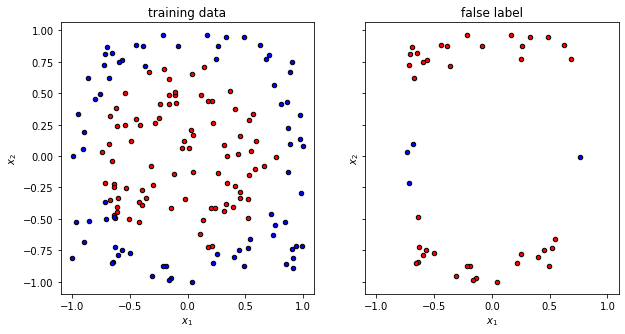

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

plot_data(x_train, y_train, fig=f, ax=ax1, title="training data")
plot_data(x_false, y_false, fig=f, ax=ax2, title="false label")

## Test

Having finished the training, we can test the circuit now on data points that it has never seen.

The circuit has a test accuracy of 0.78


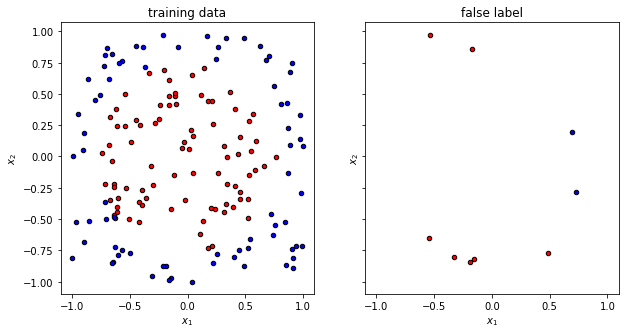

In [ ]:
test_accuracy, y_test_pred = get_accuracy(
    qc, weights=opt_weights,  alphas = opt_alphas, betas = opt_betas, gammas = opt_gammas, xvals=x_test, yvals=y_test
)

false_label = abs(y_test_pred - y_test) > 0

x_false = x_test[false_label]
y_false = y_test_pred[false_label]

print(f"The circuit has a test accuracy of {test_accuracy:.2}")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

plot_data(x_train, y_train, fig=f, ax=ax1, title="training data")
plot_data(x_false, y_false, fig=f, ax=ax2, title="false label")

## Summary and outlook

In this tutorial, we have seen that the data reuploading circuit can be extended to handle multiple input parameters. So have put everything together that we would like at this stage:

1. More input parameters can be handle through more gates in the layer $S(\mathbf{x}_i)$
2. More complex data structures can be embedded through deeper circuit structures. 

Improved circuits typically work with tuning of:

- Different optimizers.
- Cost functions that are easier to differentiate.
- Libraries that perform faster differentiation.
- More parameters for the circuits.

Up to this point we have exclusively worked with circuits that work on a single qubit. While this allowed us to learn more fundamental concepts, it clearly ignores one important parameter that is commonly seen as a differentiator between classical and quantum systems, namely entanglement. So in the next and last tutorial of this series we will work with multiple qubits, entangle them and see how we can systematically study the role of entanglement in the circuit performance.

